In [6]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import numpy as np
import skimage.color, skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA
from scipy import signal
# from image import *
import cv2

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
source = loadmat('/content/drive/MyDrive/Urban_R162.mat')

In [9]:
source_info=scipy.io.whosmat('/content/drive/MyDrive/Urban_R162.mat')
print(source_info)

[('SlectBands', (162, 1), 'double'), ('nRow', (1, 1), 'double'), ('nCol', (1, 1), 'double'), ('nBand', (1, 1), 'double'), ('Y', (162, 94249), 'double'), ('maxValue', (1, 1), 'double')]


In [10]:
transformed=source['Y'].T
print(transformed.shape)

(94249, 162)


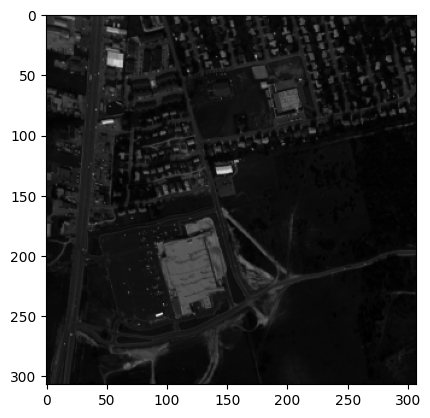

In [11]:
red_band=transformed[:,5].reshape(307,307)
green_band=transformed[:,10].reshape(307,307)
blue_band=transformed[:,15].reshape(307,307)
gray_image=(red_band+green_band+blue_band)/3

plt.imshow(gray_image,cmap='gray')

In [12]:
data=scipy.io.loadmat('/content/drive/MyDrive/end5_groundTruth.mat')

In [13]:
info=scipy.io.whosmat('/content/drive/MyDrive/end5_groundTruth.mat')
print(info)

[('cood', (5, 1), 'cell'), ('A', (5, 94249), 'double'), ('M', (162, 5), 'double'), ('nEnd', (1, 1), 'double'), ('nRow', (1, 1), 'double'), ('nCol', (1, 1), 'double')]


In [14]:
print(data['A'][0])

[0.88483664 0.85164916 0.8422391  ... 0.         0.         0.        ]


In [15]:
print(data['cood'])

[[array(['1-Asphalt Road'], dtype='<U14')]
 [array(['2-Grass'], dtype='<U7')]
 [array(['3-Tree'], dtype='<U6')]
 [array(['4-Roof'], dtype='<U6')]
 [array(['5-Dirt'], dtype='<U6')]]


In [16]:
truth_img=data['A'].T

In [17]:
print(truth_img.shape)

(94249, 5)


In [18]:
print(truth_img[0])

[0.88483664 0.         0.         0.         0.11516336]


In [19]:
print(truth_img[:,0])

[0.88483664 0.85164916 0.8422391  ... 0.         0.         0.        ]


In [20]:
print(truth_img[:,0].reshape(307,307))

[[0.88483664 0.85164916 0.8422391  ... 0.         0.         0.        ]
 [0.83468167 0.82754168 0.83440335 ... 0.         0.         0.        ]
 [0.84151644 0.83491719 0.83962607 ... 0.         0.         0.25258319]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [21]:
w=h=307

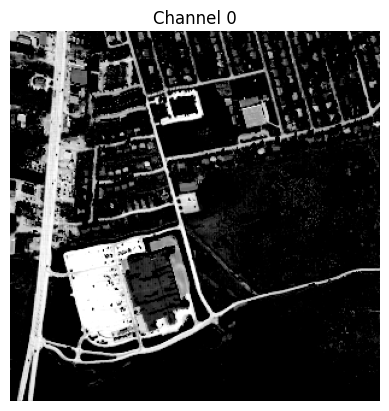

In [22]:
channel_0 = truth_img[:, 0].reshape(w, h)


plt.imshow(channel_0, cmap='gray')
plt.title('Channel 0')
plt.axis('off')  #
plt.show()

In [23]:
p=np.concatenate(
                    (truth_img[:, 0].reshape(w, h), truth_img[:, 1].reshape(w, h), truth_img[:, 2].reshape(w, h),
                     truth_img[:, 3].reshape(w, h), truth_img[:, 4].reshape(w, h)), -1)

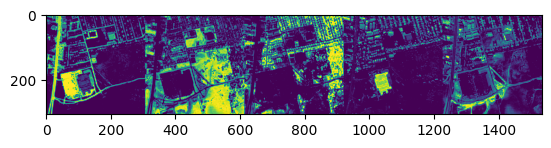

In [24]:
plt.imshow(np.concatenate((truth_img[:,0].reshape(w,h),truth_img[:,1].reshape(w,h),truth_img[:,2].reshape(w,h),truth_img[:,3].reshape(w,h),truth_img[:,4].reshape(w,h)),-1))
plt.show()

In [25]:
source = loadmat('/content/drive/MyDrive/Urban_R162.mat')
truth = loadmat('/content/drive/MyDrive/end5_groundTruth.mat')
source_data = source['Y']
X_all = source_data.T/255
truth_data = truth['A']
truth_img = truth_data.T
if 0:#os_i!= 0:
  truth_img = np.load('plots/accumulate_5.npy')

asa = np.max(truth_img,-1)
aaa= truth_img - np.repeat(np.expand_dims(asa,-1),5,-1)
aaa[aaa ==0] =1
aaa[aaa<=0] = 0
truth_img = aaa


In [26]:
w = 307
h=307
ica = FastICA(n_components=5,max_iter=200, tol=0.001)
S_ = ica.fit_transform(X_all)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [27]:

def GaussianMatrix(X,sigma):
    G = torch.mm(X, X.T)
    K = 2*G-(torch.diag(G).reshape([1,G.size()[0]]))
    K = 1/(2*sigma**2)*(K-(torch.diag(G).reshape([G.size()[0],1])))
    K = torch.exp(K)

    return K

In [28]:
def MMI8(variable1, variable2, variable3, variable4, variable5, variable6, variable7, variable8, sigma1, alpha):
    input1 = variable1
    K_x = GaussianMatrix(input1, sigma1) / (input1.size(dim=0))
    L_x, _ = torch.linalg.eigh(K_x, UPLO='L')
    lambda_x = torch.abs(L_x)

    H_x = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_x ** alpha)))

    input2 = variable2
    K_y = GaussianMatrix(input2, sigma1) / (input2.size(dim=0))
    L_y, _ = torch.linalg.eigh(K_y, UPLO='L')
    lambda_y = torch.abs(L_y)

    H_y = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_y ** alpha)))

    input3 = variable3
    K_z = GaussianMatrix(input3, sigma1) / (input3.size(dim=0))
    L_z, _ = torch.linalg.eigh(K_z, UPLO='L')
    lambda_z = torch.abs(L_z)

    H_z = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_z ** alpha)))

    input4 = variable4
    K_4 = GaussianMatrix(input4, sigma1) / (input4.size(dim=0))
    L_4, _ = torch.linalg.eigh(K_4, UPLO='L')
    lambda_4 = torch.abs(L_4)

    H_4 = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_4 ** alpha)))

    input5 = variable5
    K_5 = GaussianMatrix(input5, sigma1) / (input5.size(dim=0))
    L_5, _ = torch.linalg.eigh(K_5, UPLO='L')
    lambda_5 = torch.abs(L_5)

    H_5 = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_5 ** alpha)))

    input6 = variable6
    K_6 = GaussianMatrix(input6, sigma1) / (input6.size(dim=0))
    L_6, _ = torch.linalg.eigh(K_6, UPLO='L')
    lambda_6 = torch.abs(L_6)

    H_6 = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_6 ** alpha)))

    input7 = variable7
    K_7 = GaussianMatrix(input7, sigma1) / (input7.size(dim=0))
    L_7, _ = torch.linalg.eigh(K_7, UPLO='L')
    lambda_7 = torch.abs(L_7)

    H_7 = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_7 ** alpha)))

    input8 = variable8
    K_8 = GaussianMatrix(input8, sigma1) / (input8.size(dim=0))
    L_8, _ = torch.linalg.eigh(K_8, UPLO='L')
    lambda_8 = torch.abs(L_8)

    H_8 = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_8 ** alpha)))

    K_xyz = K_x * K_y * K_z * K_4 * K_5 * K_6 * K_7 * K_8 * (input1.size(dim=0))
    K_xyz = K_xyz / torch.sum(torch.diag(K_xyz))

    L_xyz, _ = torch.linalg.eigh(K_xyz, UPLO='L')
    lambda_xyz = torch.abs(L_xyz)

    H_xyz = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_xyz ** alpha)))

    return H_x + H_y + H_z + H_4 + H_5 + H_6 + H_7 + H_8 - H_xyz

In [29]:


def MMI5(variable1, variable2, variable3, variable4, variable5, sigma1, alpha):
    input1 = variable1
    K_x = GaussianMatrix(input1, sigma1) / (input1.size(dim=0))
    L_x, _ = torch.linalg.eigh(K_x, UPLO='L')
    lambda_x = torch.abs(L_x)

    H_x = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_x ** alpha)))

    input2 = variable2
    K_y = GaussianMatrix(input2, sigma1) / (input2.size(dim=0))
    L_y, _ = torch.linalg.eigh(K_y, UPLO='L')
    lambda_y = torch.abs(L_y)

    H_y = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_y ** alpha)))

    input3 = variable3
    K_z = GaussianMatrix(input3, sigma1) / (input3.size(dim=0))
    L_z, _ = torch.linalg.eigh(K_z, UPLO='L')
    lambda_z = torch.abs(L_z)

    H_z = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_z ** alpha)))

    input4 = variable4
    K_4 = GaussianMatrix(input4, sigma1) / (input4.size(dim=0))
    L_4, _ = torch.linalg.eigh(K_4, UPLO='L')
    lambda_4 = torch.abs(L_4)

    H_4 = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_4 ** alpha)))

    input5 = variable5
    K_5 = GaussianMatrix(input5, sigma1) / (input5.size(dim=0))
    L_5, _ = torch.linalg.eigh(K_5, UPLO='L')
    lambda_5 = torch.abs(L_5)

    H_5 = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_5 ** alpha)))

    K_xyz = K_x * K_y * K_z * K_4 * K_5 * (input1.size(dim=0))
    K_xyz = K_xyz / torch.sum(torch.diag(K_xyz))

    L_xyz, _ = torch.linalg.eigh(K_xyz, UPLO='L')
    lambda_xyz = torch.abs(L_xyz)

    H_xyz = (1 / (1 - alpha)) * torch.log2((torch.sum(lambda_xyz ** alpha)))

    return H_x + H_y + H_z + H_4 + H_5 - H_xyz

In [30]:
input_dim = 162
output_dim = 8
output_dim_2 = 5
h_n = 9000
w = 307
h=307

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(input_dim, int(h_n/1))
        self.norm1 = nn.BatchNorm1d(h_n)
        self.fc2 = nn.Linear(int(h_n/1), int(h_n/1))
        self.norm2 = nn.BatchNorm1d(h_n)
        self.fc3 = nn.Linear(h_n, int(h_n/1))
        self.norm3 = nn.BatchNorm1d(h_n)
        self.fc4 = nn.Linear(int(h_n/1), int(h_n/1))
        self.norm4 = nn.BatchNorm1d(h_n)
        self.fc5 = nn.Linear(int(h_n/1), h_n)
        self.norm5 = nn.BatchNorm1d(h_n)
        self.fc6 = nn.Linear(h_n, int(h_n/1))
        self.norm6 = nn.BatchNorm1d(h_n)
        self.fc7 = nn.Linear(h_n, 128)
        self.norm7 = nn.BatchNorm1d(128)

        self.fc8 = nn.Linear(128, output_dim)
        self.fc9 = nn.Linear(128, output_dim_2)

    def single_power_step(self, A, x):
        x = torch.matmul(A, x)
        x = x/torch.norm(x)
        return x
    def alt_matrix_power(self, A, x, power):
        iter_count_tf = 0

        it = 0
        while it<power:
            it+=1
            x = self.single_power_step(A, x)

        e = torch.norm(torch.matmul(A, x))
        return x, e




    def alt_power_whitening(self, input_tensor, output_dim, n_iterations=250, **kwargs):
        R = torch.empty([output_dim,output_dim]).normal_(mean=0,std=1).cuda()
        W = torch.zeros([output_dim,output_dim]).cuda()
        input_tensor - input_tensor.mean(0)[None,:]
        C = torch.matmul(input_tensor.T, input_tensor)/input_tensor.shape[0]
        iter_count_tf = 0
        condition = lambda it, C, W, R: it<output_dim
        it = 0
        while it<output_dim:
            v, l = self.alt_matrix_power(C, R[:, it, None], n_iterations)
            it+=1
            C = C - l * torch.matmul(v, v.T)
            W = W + 1 / torch.sqrt(l) * torch.matmul(v, v.T)
        whitened_output = torch.matmul(input_tensor, W.T)
        return whitened_output, W, input_tensor.mean(0), C



    def forward(self, x):

        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        x = F.relu(self.norm3(self.fc3(x)))
        x = F.relu(self.norm4(self.fc4(x)))
        x = F.relu(self.norm5(self.fc5(x)))
        x = F.relu(self.norm6(self.fc6(x)))
        x = F.relu(self.norm7(self.fc7(x)))


        x1 = self.fc8(x)
        x1 = F.softmax(x1,-1)
        x1 = self.alt_power_whitening(x1, output_dim)[0]

        x2 = self.fc9(x)
        x2 = F.softmax(x2,-1)
        x2 = self.alt_power_whitening(x2, output_dim_2)[0]

        return x1,x2




In [32]:

model = Net()
model = nn.DataParallel(model)
model.to(device)



DataParallel(
  (module): Net(
    (fc1): Linear(in_features=162, out_features=9000, bias=True)
    (norm1): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=9000, out_features=9000, bias=True)
    (norm2): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=9000, out_features=9000, bias=True)
    (norm3): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc4): Linear(in_features=9000, out_features=9000, bias=True)
    (norm4): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc5): Linear(in_features=9000, out_features=9000, bias=True)
    (norm5): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc6): Linear(in_features=9000, out_features=9000, bias=True)
    (norm6): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [33]:

N =1000
crition = nn.MSELoss()
loss_list = []
current_loss_old =1000000

params = list(model.parameters())# + list(model2.parameters())
optimizer = optim.Adam(params, lr=0.0001)
k= 0
show_id = 1

85
[array(1.9810979, dtype=float32)]


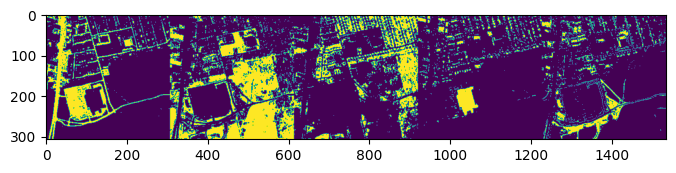

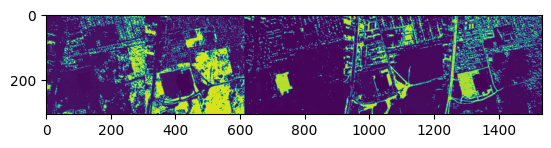

[0.1909622383261361, 0.10106208023427304, 0.12897749578244863, 0.030939320311090833, 0.1388874152510902]
0.11816570998100775


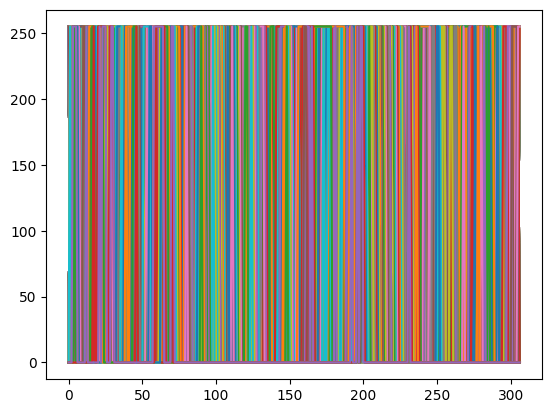

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# Assuming necessary imports and model setup are done

# Initialize an array to store abundance vectors
abundance_vectors = []
fina=show_real = np.zeros([(truth_data.T).shape[0], 5])
for ep in range(1):
    range_all = list(range(len(X_all)))
    permuted_all = list(np.random.permutation(range_all))
    X_all_shuffle = X_all[permuted_all]

    for it in range(int(len(X_all) / N)):
        xinput = X_all_shuffle[int(it * N):int(it * N) + N].astype(np.float32)

        optimizer.zero_grad()
        xinput = torch.tensor(xinput).cuda().to(device)
        latent_x, latent_x2 = model(xinput)
        sigma = 0.1
        alpha = 1.01

        loss = MMI5(latent_x2[:, 0].unsqueeze(-1), latent_x2[:, 1].unsqueeze(-1), latent_x2[:, 2].unsqueeze(-1),
                    latent_x2[:, 3].unsqueeze(-1), latent_x2[:, 4].unsqueeze(-1), sigma, alpha)

        loss.backward()
        optimizer.step()
        current_loss = loss.cpu().detach().numpy()
        loss_list.append(current_loss)
        k += 1
        if k % 85 == 0:
            print(k)
            print([current_loss])
            plt.figure(figsize=(8, 8))
            plt.subplot(4, 1, 1)
            if show_id % 2 == 0:
                show = np.zeros([(truth_data.T).shape[0], output_dim])
            else:
                show = np.zeros([(truth_data.T).shape[0], output_dim_2])

            for iij in range(int(len(X_all) / N)):
                X_sample = X_all_shuffle[iij:-1:int(int(w * h) / N)].astype(np.float32)
                # print(X_sample.shape)
                X_sample = torch.tensor(X_sample).cuda().to(device)
                if show_id % 2 == 0:
                    show_si, _ = model(X_sample)
                    show_si = show_si.cpu().detach().numpy()
                else:
                    _, show_si = model(X_sample)
                    show_si = show_si.cpu().detach().numpy()

                show[iij:-1:int(int(w * h) / N)] = show_si

            if show_id % 2 == 0:
                show_real = np.zeros([(truth_data.T).shape[0], output_dim])
            else:
                show_real = np.zeros([(truth_data.T).shape[0], output_dim_2])

            for i in range(len(show)):
                show_real[permuted_all[i]] = show[i]
            show = show_real


            show_list = []
            for j in range(len(show)):
                show_list.append(show[j])
            show_si = np.array(show_list)

            if show_id % 2 == 0:
                end_num = output_dim
            else:
                end_num = output_dim_2
            for endm in range(end_num):
                show_si[:, endm] = (show_si[:, endm] - show_si[:, endm].min()) / (
                            show_si[:, endm].max() - show_si[:, endm].min())

            show = show_si
            # Capture abundance vectors
            fina=show
            abundance_vectors.append(show)
            # if show_id % 2 == 0:
            #     plt.imshow(np.concatenate((show[:, 0].reshape(w, h), show[:, 1].reshape(w, h), show[:, 2].reshape(w, h),
            #                                show[:, 3].reshape(w, h), show[:, 4].reshape(w, h), show[:, 5].reshape(w, h),
            #                                show[:, 6].reshape(w, h), show[:, 7].reshape(w, h)), -1))
            #     plt.show()

            #     asa = np.max(show, -1)
            #     aaa = show - np.repeat(np.expand_dims(asa, -1), 8, -1)
            #     aaa[aaa == 0] = 1
            #     aaa[aaa <= 0] = 0
            #     show = aaa

            #     error_list = []

            #     index_list = [0, 1, 2, 3, 4, 5, 6, 7]
            #     for itruth in range(5):
            #         min_error = 10000000000000
            #         for ishow in range(8):
            #             single_truth = truth_img[:, itruth]
            #             single_show = show[:, ishow]

            #             mse_error = np.sum(np.abs(single_truth - single_show)) / len(single_show)
            #             if min_error > mse_error:
            #                 min_error = mse_error
            #                 index_list[itruth] = ishow

            #         error_list.append(min_error)
            #     print(error_list)
            #     print(np.mean(error_list))

            #     save_img = np.concatenate((show[:, index_list[0]].reshape(w, h), show[:, index_list[1]].reshape(w, h),
            #                                show[:, index_list[2]].reshape(w, h), show[:, index_list[3]].reshape(w, h),
            #                                show[:, index_list[4]].reshape(w, h), show[:, index_list[5]].reshape(w, h),
            #                                show[:, index_list[6]].reshape(w, h), show[:, index_list[7]].reshape(w, h)), -1)
            #     save_img = (save_img * 255).astype(np.uint8)
            #     plt.plot(save_img)
            #     plt.show()


            # else:
            if(show_id ==1)
                plt.imshow(np.concatenate(
                    (truth_img[:, 0].reshape(w, h), truth_img[:, 1].reshape(w, h), truth_img[:, 2].reshape(w, h),
                     truth_img[:, 3].reshape(w, h), truth_img[:, 4].reshape(w, h)), -1))
                plt.show()
                plt.imshow(np.concatenate((show[:, 0].reshape(w, h), show[:, 1].reshape(w, h), show[:, 2].reshape(w, h),
                                           show[:, 3].reshape(w, h), show[:, 4].reshape(w, h)), -1))
                plt.show()

                asa = np.max(show, -1)
                aaa = show - np.repeat(np.expand_dims(asa, -1), 5, -1)
                aaa[aaa == 0] = 1
                aaa[aaa <= 0] = 0
                show = aaa

                error_list = []

                index_list = [0, 1, 2, 3, 4]
                for itruth in range(5):
                    min_error = 10000000000000
                    for ishow in range(5):
                        single_truth = truth_img[:, itruth]
                        single_show = show[:, ishow]

                        mse_error = np.sum(np.abs(single_truth - single_show)) / len(single_show)
                        if min_error > mse_error:
                            min_error = mse_error
                            index_list[itruth] = ishow

                    error_list.append(min_error)
                print(error_list)
                print(np.mean(error_list))

                if 0:
                    index_list = [0, 1, 2, 3, 4]

                save_img = np.concatenate((show[:, index_list[0]].reshape(w, h), show[:, index_list[1]].reshape(w, h),
                                           show[:, index_list[2]].reshape(w, h), show[:, index_list[3]].reshape(w, h),
                                           show[:, index_list[4]].reshape(w, h)), -1)

                save_show = np.zeros(show.shape)
                for idm in range(5):
                    save_show[:, idm] = show[:, index_list[idm]]


                save_img = (save_img * 255).astype(np.uint8)
                plt.plot(save_img)
                plt.show()


# Print abundance vectors for each pixel
# for i, vector in enumerate(abundance_vectors):
#     print(f"Iteration {i}:")
#     for j, pixel_vector in enumerate(vector):
#         print(f"  Pixel {j}: {pixel_vector}")


In [57]:
print(len(loss_list))

94


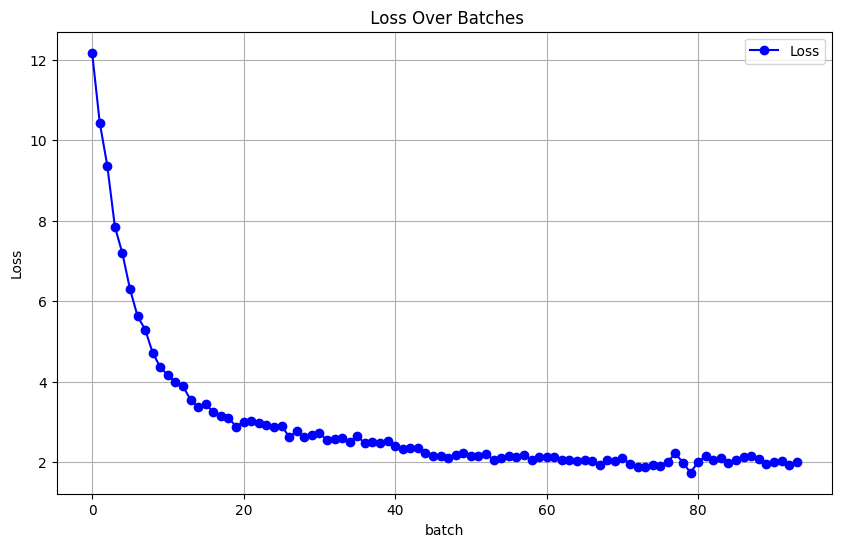

In [61]:

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(loss_list, marker='o', linestyle='-', color='b', label='Loss')
plt.title(' Loss Over Batches')
plt.xlabel('batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
ini=np.load('index_list.npy')
print(ini)

[4 1 0 2 3]


In [36]:
print(len(abundance_vectors[0]))

94249


In [37]:
abu=np.array(abundance_vectors[0])

In [38]:
print(abu.shape)

(94249, 5)


In [40]:
print(abu[:,0].reshape(w,h).shape)

(307, 307)


In [46]:
abundance_map_first_endmember=abu[:,1].reshape(w,h)


In [52]:
print(abundance_vectors[0][0])
print(abundance_vectors[0][100])
print(abundance_vectors[0][200])
print(abundance_vectors[0][300])
print(abundance_vectors[0][400])

[0.03506794 0.04879749 0.01436698 0.70606413 0.20749119]
[0.91984561 0.03762354 0.01286972 0.02570621 0.02780483]
[0.94675503 0.02800386 0.01068643 0.01530284 0.02668724]
[0.0493369  0.0503564  0.0147324  0.02798175 0.84311336]
[0.03974448 0.92806479 0.00769492 0.03537704 0.03826469]


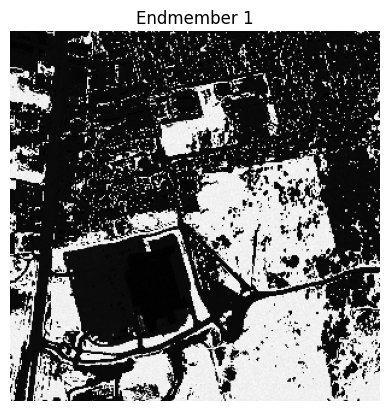

In [47]:

# Display the first channel
plt.imshow(abundance_map_first_endmember, cmap='gray')  # Use 'gray' colormap for single-channel images
plt.title('Endmember 1')
plt.axis('off')  # Turn off axis
plt.show()

In [42]:
# Calculate Mean Squared Error
mse = np.mean((abu - truth_img) ** 2)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.23470369899976515
